# Repertoire classification SVM

Here we train an SVM classifier to identify the subject from which a given repertoire was isolated. Using the multiple biological replicates for each subject. The model is trained on 5 of the 6 biological replicates for each subject and tested on the remaining biological replicate from each subject. This code will train the SVM classifier and generate the following figure:

  * Lineplot of mean ROC AUC (**Figure 1i**)
 
The following Python packages are required to run this notebook:

  * numpy
  * pandas
  * scipy
  * seaborn
  * matplotlib
  * sci-kit learn
  * [abutils](https://github.com/briney/abutils)
  
They can be install by running `pip install numpy pandas scipy matplotlib seaborn sklearn abutils`

In [3]:
from __future__ import print_function, division

from itertools import cycle
import os
import subprocess as sp
import sys
import tempfile

import numpy as np
import pandas as pd

import scipy as sp
from scipy import stats, interp

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn import datasets, ensemble, metrics, naive_bayes, preprocessing, svm
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize

from abutils.utils.pipeline import list_files, make_dir
from abutils.utils.progbar import progress_bar

%matplotlib inline

### Subjects and colors

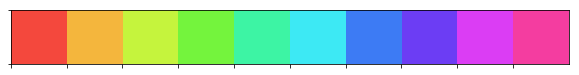

In [4]:
with open('../data_processing/data/subjects.txt') as f:
    subjects = sorted(f.read().split())

colors = sns.hls_palette(10, s=0.9)
colors[3] = sns.hls_palette(11, s=0.9)[3]
colors[4] = sns.hls_palette(12, s=0.9)[5]

color_dict = {s: c for s, c in zip(subjects, colors)}

sns.palplot(colors)

## Classifier training and evaluation

The method of evaluating the classifier is to calculate the area under the receiver operating characteristic curve (ROC AUC) 

In [5]:
def get_test_train_data(X, y, biorep_to_drop):
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    for subject in subjects:
        subX, suby = zip(*[(_X, _y) for _X, _y in zip(X, y) if _y == subject])
        X_train.extend(subX[:biorep_to_drop] + subX[biorep_to_drop + 1:])
        y_train.extend(suby[:biorep_to_drop] + suby[biorep_to_drop + 1:])
        X_test.append(subX[biorep_to_drop])
        y_test.append(suby[biorep_to_drop])
    return X_train, X_test, y_train, y_test

In [8]:
input_directory = '../data_processing/data/repertoire_classification/subsamples_vj-cdr3len'
iterations = 20

np.random.seed(1234)
aucs_by_subject = {}

for subsample_size in list(range(10, 100, 10)) + list(range(100, 1001, 100)):
    aucs_by_subject[subsample_size] = {s: [] for s in subjects}
    for i in range(iterations):
        
        # make a DataFrame of test/training data
        Xtrain = {}
        for biorep in range(1, 7):
            files = [f for f in list_files(input_directory) if '_{}-{}'.format(subsample_size, biorep) in os.path.basename(f)]
            for file_ in files:
                subject = os.path.basename(file_).split('_')[0]
                with open(file_) as f:
                    lines = [l for l in f.read().split('\n') if l.strip()]
                    line = np.random.choice(lines)
                    l = line.strip().split(',')
                    Xtrain[os.path.basename(file_)] = {v.split(':')[0]: float(v.split(':')[1]) / subsample_size for v in l}
        Xtrain_df = pd.DataFrame(Xtrain).fillna(0)

        # split into test/train datasets (leave-one-out cross validation)
        X = [list(Xtrain_df[col]) for col in Xtrain_df.columns.values]
        y = [col.split('_')[0] for col in Xtrain_df.columns.values]
        biorep_to_drop = np.random.choice(range(6))
        X_train, X_test, y_train, y_test = get_test_train_data(X, y, biorep_to_drop)
        y_train = label_binarize(y_train, classes=sorted(list(set(y))))
        y_test = label_binarize(y_test, classes=sorted(list(set(y))))
        n_classes = y_train.shape[1]
        random_state = np.random.RandomState(0)

        # Learn to predict each class against the other
        classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                         random_state=random_state))
        clf = classifier.fit(X_train, y_train)
        y_score = clf.decision_function(X_test)

        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        for i, subject in zip(range(n_classes), subjects):
            aucs_by_subject[subsample_size][subject].append(roc_auc[i])

## Plot mean AUC for each subsample

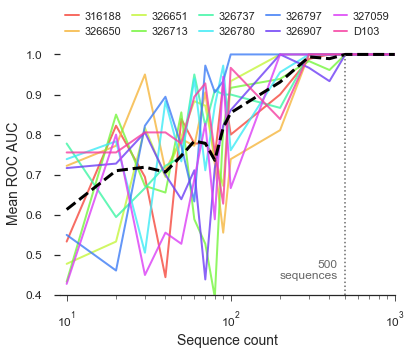

In [9]:
#calculate the overall mean (combined mean of all subjects)
mean_ys = []
for subsample_size in sorted(aucs_by_subject.keys()):
    means = []
    for s in sorted(aucs_by_subject[subsample_size].keys()):
        aucs = aucs_by_subject[subsample_size][s]
        means.append(np.mean(aucs))
    mean_ys.append(np.mean(means))

# initialize the plot
sns.set_style('white')
plt.figure(figsize=(6, 4.5))

# plot data for each subject
for subject, color in zip(subjects, colors):
    xs = sorted(aucs_by_subject.keys())
    ys = [np.mean(aucs_by_subject[x][subject]) for x in xs]
    plt.plot(xs, ys, c=color, label=subject, alpha=0.8, lw=2)

# plot the overall mean line
plt.plot(xs, mean_ys, 'k--', lw=3)

# add a horizontal reference line at 500 sequences
plt.axvline(x=500, ymin=0.0, ymax=0.99, ls=':', color=[0.4] * 3)

# style the plot
ax = plt.gca()
# add text at the 50 sequence reference line
ax.text(450,
        0.44,
        '500\nsequences',
        color=[0.4] * 3,
        ha='right',
        fontsize=12)
# set axis scale, limits and labels
ax.set_xscale('log')
ax.set_ylim((0.4, 1.01))
ax.set_xlim([9.1, 1000])
ax.set_xlabel('Sequence count', fontsize=14)
ax.set_ylabel('Mean ROC AUC', fontsize=14)
# style the ticks
ax.tick_params(axis='x', bottom=True, top=False, length=6, pad=8, labelsize=12)
ax.tick_params(axis='x', which='minor', bottom=True, top=False, length=4, pad=8)
ax.tick_params(axis='y', which='major', labelsize=12, length=6, width=1.25, pad=12, right=False)
# remove top, left and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
# draw the legend
ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.015),
          ncol=5, handlelength=1.25,
          columnspacing=1, handletextpad=0.5, 
          labelspacing=0.5, fontsize=11)

# save or show
plt.show()
# plt.subplots_adjust(top = 0.8)
# plt.savefig('/data/jupyter/repertoire fingerprinting/multiclass-svc_v-j-cdr3len_auc-vs-subsample-depth_semi-short.pdf')